# Different ways to find luminosity density

As we explained elsewhere, we calculated the star formation rate density from the luminosity function. To do so, we first need to find the luminosity density by integrating the luminosity function as follows:

$$\rho(>L_{min}) = \int_{L_{min}}^\infty L \phi(L) dL$$

Here, the lower limit of the integration is poorly defined till now. Until now, we have been using $L_{min} = 0.03L_*$ following Madau & Dickinson (2014). However, this limit is, since $L_*$ varies over redshift, is not constant over cosmic history. Plus, it is not related to some physical property of a galaxy. We want to change this by relating this lower limit of integration to the star formation rate of the galaxy. In doing so, we shall use the same conversion factor from Madau & Dickinson (2014),

$$\psi = \kappa_{FUV} \times \rho$$

Here, the symbols have their usual meanings (Note that we are corrently demonstrating for FUV only). We find that the limit of $0.03L_*$ corresponds to $\sim 0.35 M_\odot \ year^{-1}$, using this conversion factor. To find the star formation rate density more accurately, we want to decrease the lower limit of integration. In the present work, we illustrate the case for the star formation rate of $0.35 M_\odot \ year^{-1}$, $0.1 M_\odot \ year^{-1}$, $0.01 M_\odot \ year^{-1}$, $0.001 M_\odot \ year^{-1}$, $0.0001 M_\odot \ year^{-1}$ and $0.00001 M_\odot \ year^{-1}$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.constants as con
import astropy.units as u
from scipy.optimize import minimize as mz
from scipy.optimize import curve_fit as cft
import utils as utl
import os

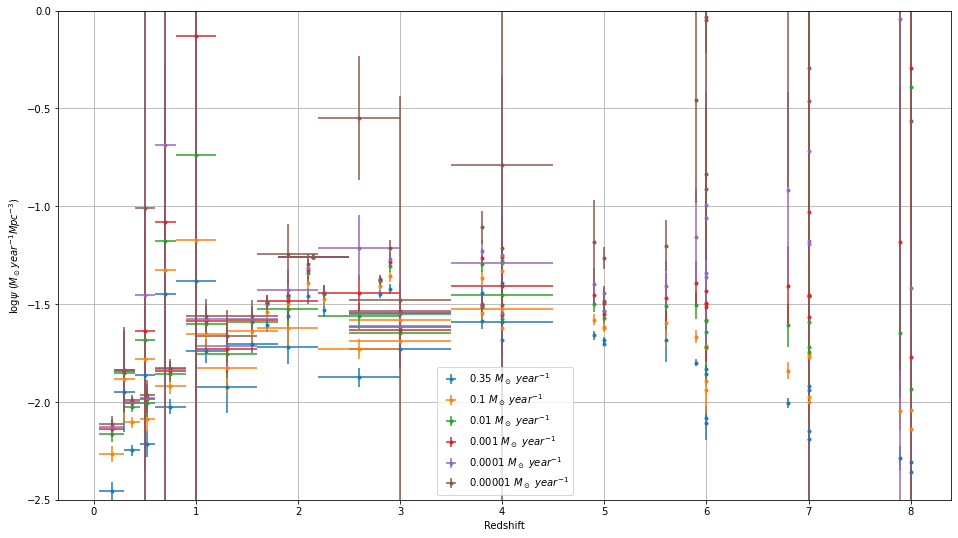

In [8]:
p1 = os.getcwd() + '/Diff_lim/'

# Different limits
lims = np.array([r'$0.35 \ M_\odot \ year^{-1}$', r'$0.1 \ M_\odot \ year^{-1}$', r'$0.01 \ M_\odot \ year^{-1}$', r'$0.001 \ M_\odot \ year^{-1}$', r'$0.0001 \ M_\odot \ year^{-1}$', r'$0.00001 \ M_\odot \ year^{-1}$'])

# Redshifts: same for all calculations
zu, zd = np.loadtxt(p1 + 'sfrd_uv_new035.dat', usecols=(1,2), unpack=True)
zcen = (zu+zd)/2
zup, zdo = np.abs(zu - zcen), np.abs(zcen - zd)

# For 0.35 M_sun year-1
sfr035, sfre035 = np.loadtxt(p1 + 'sfrd_uv_new035.dat', usecols=(3,4), unpack=True)
# For 0.1 M_sun year-1
sfr_1, sfre_1 = np.loadtxt(p1 + 'sfrd_uv_new01.dat', usecols=(3,4), unpack=True)
# For 0.01 M_sun year-1
sfr_2, sfre_2 = np.loadtxt(p1 + 'sfrd_uv_new001.dat', usecols=(3,4), unpack=True)
# For 0.001 M_sun year-1
sfr_3, sfre_3 = np.loadtxt(p1 + 'sfrd_uv_new0001.dat', usecols=(3,4), unpack=True)
# For 0.0001 M_sun year-1
sfr_4, sfre_4 = np.loadtxt(p1 + 'sfrd_uv_new00001.dat', usecols=(3,4), unpack=True)
# For 0.00001 M_sun year-1
sfr_5, sfre_5 = np.loadtxt(p1 + 'sfrd_uv_new000001.dat', usecols=(3,4), unpack=True)

# All SFRDs in one array
sfr_all = [sfr035, sfr_1, sfr_2, sfr_3, sfr_4, sfr_5]
sfre_all = [sfre035, sfre_1, sfre_2, sfre_3, sfre_4, sfre_5]

log_sfr_all, log_sfre_all = [], []
for i in range(len(sfr_all)):
    ab, cd = utl.log_err(sfr_all[i], sfre_all[i])
    log_sfr_all.append(ab)
    log_sfre_all.append(cd)

plt.figure(figsize=(16,9))
for i in range(len(lims)):
    plt.errorbar(zcen, log_sfr_all[i], xerr=[zup, zdo], yerr=log_sfre_all[i], fmt='.', label=lims[i])

plt.xlabel('Redshift')
plt.ylabel(r'$\log{\psi}$ ($M_\odot year^{-1} Mpc^{-3}$)')
plt.grid()
plt.ylim([-2.5, 0])
plt.legend(loc='best')

Well, of course, it looks a bit crowdy --- there are too many points in it. To see the overall pattern, we fit a function to these data points, and see how the overall trend looks like. As usual, we use the best fitted function from Madau & Dickinson (2014),

$$ \psi(z) = A \frac{(1+z)^{B}}{1 + [(1+z)/C]^{D}} M_\odot \ year^{-1} Mpc^{-3}$$

here, $A$, $B$, $C$ and $D$ are variables.

We use `scipy.optimize.minimize` function to perform this task. The idea is to compute the maximum likelihood function.

In [ ]:
# New model
def psi_new(z, aa, bb, cc, dd):
    ab = (1+z)**bb
    cd = ((1+z)/cc)**dd
    ef = aa*ab/(1+cd)
    return ef

# Negative likelihood function
def min_log_likelihood(x):
    model = psi_new(zcen_uv, x[0], x[1], x[2], x[3])
    chi2 = (sfrd_uv - model)/sfrd_uv_err
    chi22 = np.sum(chi2**2)
    yy = 0.5*chi22 + np.sum(np.log(sfrd_uv_err))
    return yy

best_fit_params = []
